Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

In [1678]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn 
import torch.distributions as dist
%matplotlib inline

# Bayesian linear classifiers

In this example you are going to fit a Bayesian logistic regression model, using different sets of features on data $\mathbf{x} \in \mathbb{R}^2$.

The first one is a "simple" set of features, with just the two input features plus an intercept:

$$\begin{align*}
\phi_{\text{simple}}(\mathbf{x}) &= [ 1, x_1, x_2 ]
\end{align*}$$

The second is a set of quadratic polynomial features,

$$\begin{align*}
\phi_{\text{quadratic}}(\mathbf{x}) &= [ 1, x_1, x_2, x_1x_2, x_1^2, x_2^2 ].
\end{align*}$$

Beyond that, it is up to you! You will have to choose features that you think are appropriate for the data.
This example just includes quadratic terms, but you could also include higher order polynomial terms (e.g. $x_1^3, x_2^3$) or completely different features alltogether. 
It's up to you — but you should be prepared to justify your choice!

Then, in the last section, you will try using deep learning to learn features (instead of hand-crafting them) — you can then compare these features and predictions and consider what is really best.

You will also fit the model in two different ways:

1. MAP estimation (penalized maximum likelihood)
2. Laplace approximation (a Gaussian approximate posterior, centered at the mode)

Here is a synthetic dataset that we'll be working with (plotting the training set only):

(-2.0, 2.0)

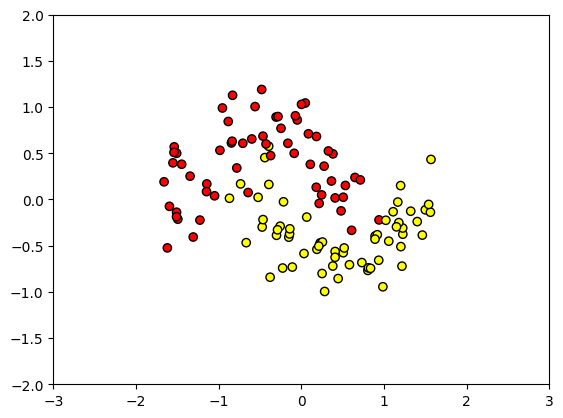

In [1679]:
dataset, validation_set = torch.load("two_moons.pt", weights_only=False)
X_train, y_train = dataset.tensors
X_test, y_test = validation_set.tensors

plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='autumn', edgecolor='k');
plt.xlim(-3,3)
plt.ylim(-2,2)

Here are definitions of two different feature maps, the "simple" one and the "quadratic" one.

They define feature spaces in $\mathbb{R}^3$ and $\mathbb{R}^6$, respectively.

In [1680]:
def features_simple(X):
    return torch.concat((torch.ones_like(X[:,:1]), X), -1)

def features_quadratic(X):
    interactions = X.prod(-1, keepdim=True)
    return torch.concat((torch.ones_like(X[:,:1]), 
                         X, X.pow(2), interactions), -1)

print("Dimension of Phi, `features_simple`:", features_simple(X_train).shape)
print("Dimension of Phi, `features_quadratic`:", features_quadratic(X_train).shape)

Dimension of Phi, `features_simple`: torch.Size([120, 3])
Dimension of Phi, `features_quadratic`: torch.Size([120, 6])


# TASK #1 (3 points): Define the model

The Bayesian logistic regression model we are working with has the form
$$\begin{align*}
\mathbf{w} &\sim \mathcal{N}(0, \sigma^2 \mathbf{I}) \\
\hat y_i &= \mathrm{Logistic}(\mathbf{w}^\top \phi(\mathbf{x}_i)) \\
y_i &\sim \mathrm{Bernoulli}(\hat y_i)
\end{align*}$$
where $i = 1,\dots, N$ and the Logistic function is defined
$$\begin{align*}
\mathrm{Logistic}(z) &= \frac{1}{1 + \exp\{-z\}}.
\end{align*}$$
It's implemented in pytorch as `torch.sigmoid`.

The first step is to define two functions, one to make predictions given a weight vector $\mathbf{w}$ and inputs $\Phi$, and one which computes the log joint probability

$$\log p(\mathbf{y}, \mathbf{w} | \mathbf{\Phi}, \sigma^2).$$

I've done the first one for you.

In [1681]:
def predict_probs_MAP(Phi, w):
    """
    Given a "design matrix" Phi, and a point estimate w, compute p(y = 1 | Phi, w)
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    w     : (D,) vector of weights

    OUTPUT:
    y_hat : (N,) vector of probabilities p(y=1 | Phi, w)
    """
    return torch.sigmoid(Phi @ w)

In [1682]:
def log_joint(Phi, y, w, sigma=10):
    """
    Compute the joint probability of the data and the latent variables.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones
    w     : (D,) vector of weights
    sigma : scalar, standard deviation of Gaussian prior distribution p(w).
            Leave this set to sigma=10 for purposes of this exercise

    OUTPUT:
    log_joint : the log probability log p(y, w | Phi, sigma), a torch scalar
        
    """

    # YOUR CODE HERE
    # p(y, w | Phi, sigma) = p(w | y, Phi, sigma) * p(y | Phi, sigma)
    log_likelihood = dist.Normal(0, sigma).log_prob(w).sum()
    log_prior_y = dist.Bernoulli(predict_probs_MAP(Phi, w)).log_prob(y).sum()
    log_joint = log_likelihood + log_prior_y
    return log_joint

In [1683]:
# (GRADING)

In [1684]:
# (GRADING)

# TASK 2 (5 points): Implement MAP estimation

Now you need to write a function which performs MAP estimation, i.e. penalized maximum likelihood estimation.

This function should find the value $\mathbf{w}_{MAP}$ that maximizes the log joint, i.e.

$$\mathbf{w}_{MAP} = \mathrm{argmax}_{\mathbf{w}}\log p(\mathbf{y}, \mathbf{w} | \mathbf{\Phi}, \sigma^2).$$

To do this, you should **use pytorch autograd tools**. This will involve defining an initial value of the weights, computing a scalar loss function, and calling `.backward()`, and then performing gradient-based optimization. Take a look at the demo notebooks from previous lectures for examples…!

* You **may feel free to use classes from `torch.optim`**. I would suggest the use of `torch.optim.SGD` or `torch.optim.Adagrad`.
* Regardless of how you do this, you will need to decide on a stopping criteria for your optimization routine.
* You will also need to decide on how to set the parameters (learning rate, momentum, anything else!) for your selected optimizer.

Also, **your code should work for ANY features!**. We will test this out on not just the "simple" and "quadratic" features above, but also on your own custom choice of features.

In [1685]:
def find_MAP(Phi, y):
    """
    Find the MAP estimate of the log_joint method.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones


    OUTPUT:
    w      : (D,) vector of optimized weights
    losses : list of losses at each iteration of the optimization algorithm.
             Should be a list of scalars, which can be plotted afterward to
             diagnose convergence.
    """

    weights = torch.zeros(Phi.shape[1]).requires_grad_(True)
    losses = []
    
    # YOUR CODE HERE
    max_iterations = 10000
    tol = 1e-3
    loss_prev = delta = np.inf
    iter_count = 0

    optimiser = torch.optim.Adagrad([weights])

    while delta > tol and iter_count < max_iterations:
        optimiser.zero_grad()
        loss = -log_joint(Phi, y, weights)
        loss.backward()
        optimiser.step()
        losses.append(loss.item())
        delta = loss_prev - loss
        loss_prev = loss
        iter_count += 1
    return weights.detach(), losses


### The following two cells call `find_MAP` to compute $\mathbf{w}$ for both choices of features.

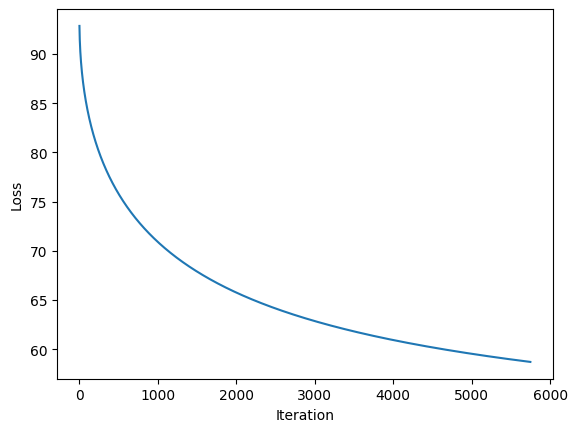

In [1686]:
w_MAP_simple, losses = find_MAP(features_simple(X_train), y_train)
plt.plot(losses);
plt.xlabel("Iteration")
plt.ylabel("Loss");

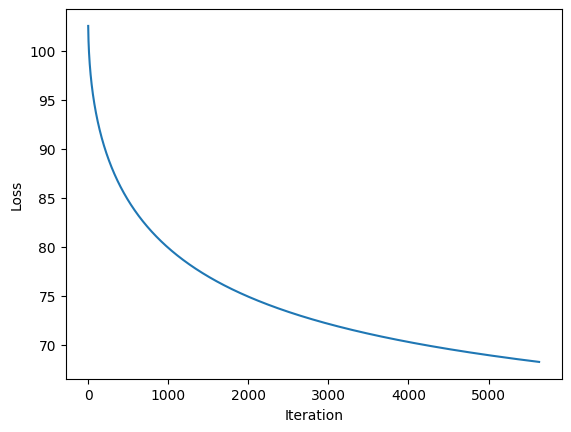

In [1687]:
w_MAP_quad, losses = find_MAP(features_quadratic(X_train), y_train)
plt.plot(losses);
plt.xlabel("Iteration")
plt.ylabel("Loss");

In [1688]:
# (GRADING)

In [1689]:
# (GRADING)

## Visualization: The following code visualizes the classifier result

It plots the probability of being one class or the other using a color contour plot.

The decision boundary is a dashed black line.

In [1690]:
def plot_boundary(X, y, pred):
    h = 0.2
    x_min, x_max = -5, 5
    y_min, y_max = -3, 3
    xx, yy = np.meshgrid(np.arange(float(x_min), float(x_max), h),
                         np.arange(float(y_min), float(y_max), h))

    Z = pred(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=.8, levels=np.linspace(0, 1, 8), cmap='autumn')
    
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='autumn', edgecolor='k');
    plt.contour(xx, yy, Z, levels=(0.5,), linestyles='dashed');
    
    # Plot the testing points
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())

Simple features: training accuracy = 0.81, test accuracy = 0.83


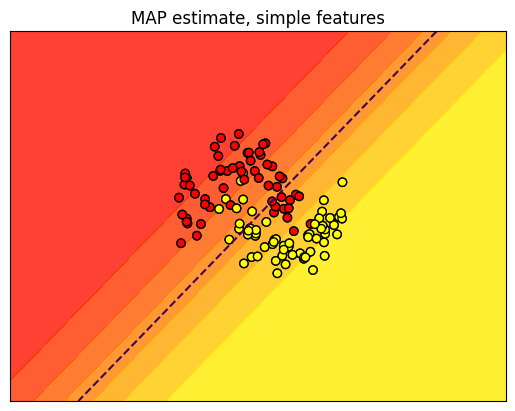

In [1691]:
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_simple(X), w_MAP_simple))
plt.title("MAP estimate, simple features")
train_accuracy = (predict_probs_MAP(features_simple(X_train), w_MAP_simple).round() == y_train).float().mean()
test_accuracy = (predict_probs_MAP(features_simple(X_test), w_MAP_simple).round() == y_test).float().mean()
print("Simple features: training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))

Quadratic features: training accuracy = 0.81, test accuracy = 0.82


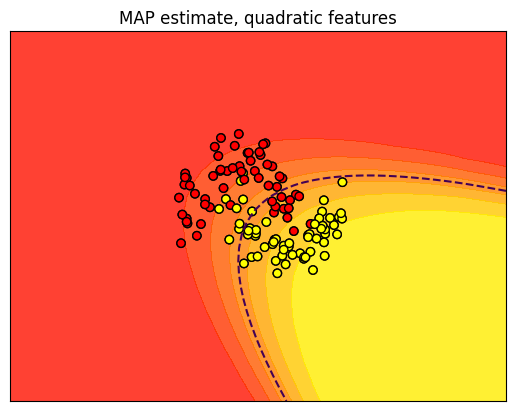

In [1692]:
plot_boundary(X_train, y_train,
              lambda X: predict_probs_MAP(features_quadratic(X), w_MAP_quad))
plt.title("MAP estimate, quadratic features")
train_accuracy = (predict_probs_MAP(features_quadratic(X_train), w_MAP_quad).round() == y_train).float().mean()
test_accuracy = (predict_probs_MAP(features_quadratic(X_test), w_MAP_quad).round() == y_test).float().mean()
print("Quadratic features: training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))

# TASK #3 (4 points): Laplace approximation

In the next section, you will fit an approximate posterior over the weights by using the Laplace approximation around the mode $\mathbf{w}_{MAP}$ of the distribution you found above.

This requires completing two functions:

1. `compute_laplace_Cov` takes the data and the MAP estimate, and outputs a covariance matrix defined as the negative inverse Hessian of the log target density. (See the week 4 lecture slides for details on how to compute this!)
2. `predict_bayes` makes predictions on new data points, by approximating $\int p(y | x, w)p(w | \mathcal{D})dw$ when using a Gaussian approximation to $p(w | \mathcal{D})$. In the week 4 lecture slides we discussed three different ways of computing this — it is up to you to decide what method you would prefer, and implement it.

In [1693]:
def compute_laplace_Cov(Phi, y, w_MAP, sigma=10):
    """
    Compute the Laplace approximation of the posterior covariance 
    in a logistic regression setting.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones
    w_MAP : (D,) vector of optimized weights, at a mode of the target density
    sigma : scalar, standard deviation of Gaussian prior distribution p(w).
            Leave this set to sigma=10 for purposes of this exercise

    OUTPUT:
    Cov : (D, D) posterior covariance matrix estimate defined by the Laplace 
          approximation
    """
    
    # YOUR CODE HERE
    y_hat = predict_probs_MAP(Phi, w_MAP)
    prior_precision = (1.0/sigma**2)*torch.eye(Phi.shape[1])    
    posterior_precision = Phi.T @ ((y_hat*(1.0-y_hat)).unsqueeze(1) * Phi) + prior_precision
    Cov = torch.linalg.inv(posterior_precision)
    return Cov

In [1694]:
def predict_bayes(Phi, w_MAP, Cov):
    """
    Make predictions on new data points using an approximate posterior 
    w ~ MultivariateNormal(w_MAP, Cov)
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    w_MAP : (D,) vector of optimized weights, at a mode of the target density
    Cov   : (D, D) approximate posterior covariance matrix
    
    OUTPUT:
    y_hat : (N,) vector of probabilities p(y=1 | Phi)
    """
    
    # YOUR CODE HERE
    # # MC Approach
    # mc_samples = 1000
    # posterior = dist.MultivariateNormal(w_MAP, Cov)
    # w_samples = posterior.sample((mc_samples,)).T

    # y_hat = predict_probs_MAP(Phi, w_samples).mean(dim=1)
    # return y_hat
    
    # Approximation Approach
    mu_a = Phi @ w_MAP
    var_a = (Phi @ Cov * Phi).sum(dim=1)
    y_hat = torch.sigmoid(mu_a / torch.sqrt(1.0 + (np.pi / 8.0) * var_a))
    return y_hat

### The following cells call your functions above to compute the Laplace approximation and visualize the posterior predictive distribution.

In [1695]:
Cov_simple = compute_laplace_Cov(features_simple(X_train), y_train, w_MAP_simple)

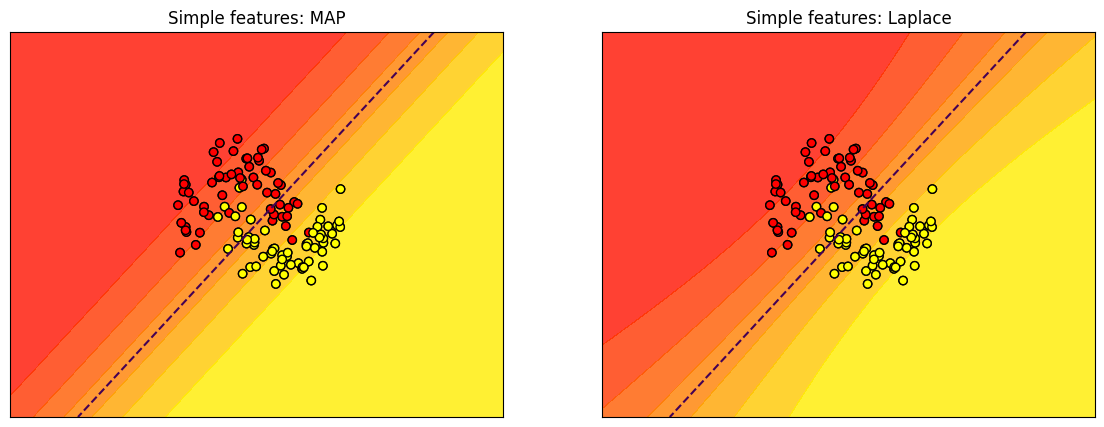

In [1696]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title("Simple features: MAP")
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_simple(X), w_MAP_simple))

plt.subplot(122)
plt.title("Simple features: Laplace")
plot_boundary(X_train, y_train, 
              lambda X: predict_bayes(features_simple(X), w_MAP_simple, Cov_simple))

In [1697]:
Cov_quad = compute_laplace_Cov(features_quadratic(X_train), y_train, w_MAP_quad)

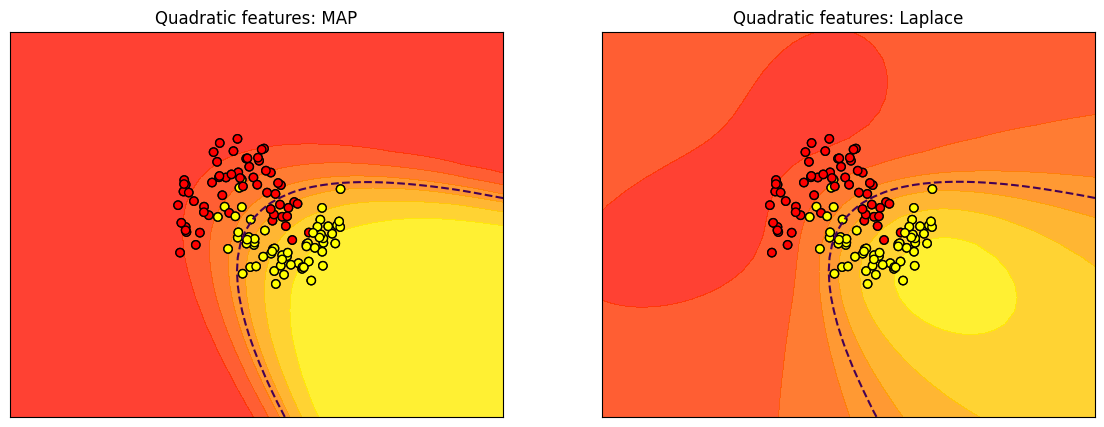

In [1698]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title("Quadratic features: MAP")
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_quadratic(X), w_MAP_quad))

plt.subplot(122)
plt.title("Quadratic features: Laplace")
plot_boundary(X_train, y_train, 
              lambda X: predict_bayes(features_quadratic(X), w_MAP_quad, Cov_quad))

In [1699]:
# (GRADING)

In [1700]:
# (GRADING)

In [1701]:
# (GRADING)

# TASK #4 (2 points): Model comparison

You can compute the marginal likelihood approximation defined by the Laplace approximation.

This estimate of the evidence can be used, even just looking at the training data, to help decide which of the two feature maps is more appropriate and better fits the data.

This can help guard against potential overfitting if using features that are "too complex".

In [1702]:
def compute_laplace_log_evidence(Phi, y, w_MAP, Cov):
    """
    This computes the Laplace approximation to the marginal likelihood,
    as defined in the Week 5 lectures.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones
    w_MAP : (D,) vector of optimized weights, at a mode of the target density
    Cov   : (D, D) approximate posterior covariance matrix
    
    OUTPUT:
    log_evidence : scalar value estimating `log p(y | Phi)`
    """
    
    # YOUR CODE HERE
    D = len(w_MAP)
    log_evidence = log_joint(Phi, y, w_MAP) + np.log(2.0*np.pi)*D/2 + np.linalg.slogdet(Cov)[1]/2

    return log_evidence

Model evidence estimate (simple features): -59.57563018798828
Model evidence estimate (quadratic features): -67.90544128417969


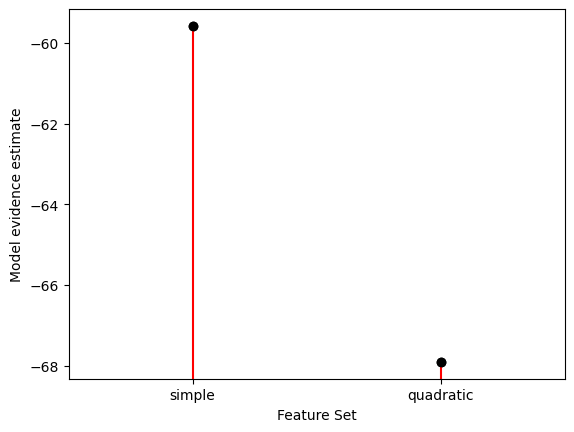

In [1703]:
def plot_evidence(names, values):
    assert len(names) == len(values)
    plt.plot(np.arange(len(names)), values, 'ko')
    ym = plt.ylim()
    for i, v in enumerate(values):
        plt.plot([i,i], [ym[0],v], 'r-')
    plt.plot(np.arange(len(names)), values, 'ko')
    plt.xticks(np.arange(len(names)), names)
    plt.xlabel("Feature Set")
    plt.ylabel("Model evidence estimate")
    plt.ylim(ym) 
    plt.xlim(-0.5, len(names)-0.5)

print("Model evidence estimate (simple features):",
      compute_laplace_log_evidence(features_simple(X_train), y_train, w_MAP_simple, Cov_simple).item())

print("Model evidence estimate (quadratic features):",
      compute_laplace_log_evidence(features_quadratic(X_train), y_train, w_MAP_quad, Cov_quad).item())

plot_evidence(("simple", "quadratic"),
              (compute_laplace_log_evidence(features_simple(X_train), y_train, w_MAP_simple, Cov_simple).item(),
               compute_laplace_log_evidence(features_quadratic(X_train), y_train, w_MAP_quad, Cov_quad).item()))

In [1704]:
# (GRADING)

# TASK #5 (2 points): Define your own feature space

Your next task is to define your own, custom feature space! This can be practically any deterministic function from $\mathbb{R}^2$ to $\mathbb{R}^D$, and you even get to pick the dimensionality $D$.

In the following cells, you first define your feature space, and then we estimate the posterior using your code above. We report training accuracy, test accuracy, and model evidence, as well as plot the decision boundaries.

Feel free to get quite creative here! However, you will be asked to defend your choice of feature space in the free-answer section at the bottom.

**Make sure when you submit, you include whatever you consider the "best" possible choice!**

In [1705]:
def features_student(X):
    """
    Compute your own, custom set of features!
    
    INPUT:
    X      : (N, 2) tensor of raw input data
    
    OUTPUT:
    Phi    : (N, D) tensor of transformed inputs
    """
    
    # YOUR CODE HERE
    xlim = 3
    ylim = 2
    x_centers = torch.linspace(-xlim, xlim, 10)
    y_centers = torch.linspace(-ylim, ylim, 8)

    centers = torch.stack(torch.meshgrid(x_centers, y_centers, indexing='ij'), dim=-1).reshape(-1, 2)
    

    sigma = 0.75
    distances_sq = torch.cdist(X, centers).pow(2)
    rbf_features = torch.exp(-distances_sq / (2 * sigma**2))
    return torch.concat((torch.ones_like(X[:,:1]), rbf_features), -1)

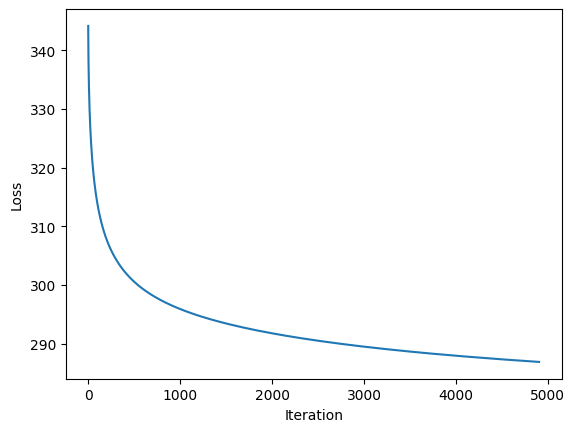

In [1706]:
w_MAP_student, losses = find_MAP(features_student(X_train), y_train)
plt.plot(losses);
plt.xlabel("Iteration")
plt.ylabel("Loss");

In [1707]:
train_accuracy = (predict_probs_MAP(features_student(X_train), w_MAP_student).round() == y_train).float().mean()
test_accuracy = (predict_probs_MAP(features_student(X_test), w_MAP_student).round() == y_test).float().mean()
print("YOUR features! Training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))



YOUR features! Training accuracy = 0.93, test accuracy = 0.93


YOUR features! Model evidence estimate: -51.87004089355469


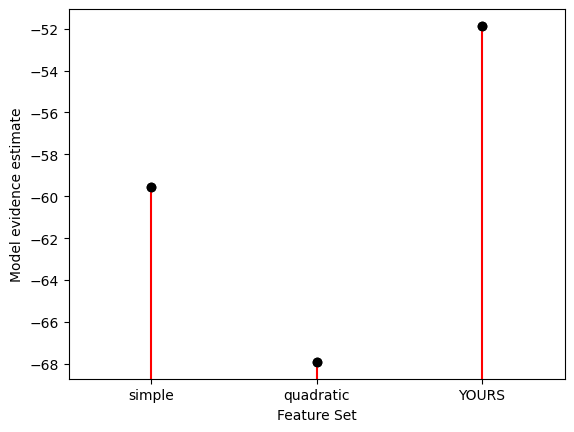

In [1708]:
Cov_student = compute_laplace_Cov(features_student(X_train), y_train, w_MAP_student)

print("YOUR features! Model evidence estimate:",
      compute_laplace_log_evidence(features_student(X_train), y_train, w_MAP_student, Cov_student).item())

plot_evidence(("simple", "quadratic", "YOURS"),
              (compute_laplace_log_evidence(features_simple(X_train), y_train, w_MAP_simple, Cov_simple).item(),
               compute_laplace_log_evidence(features_quadratic(X_train), y_train, w_MAP_quad, Cov_quad).item(),
               compute_laplace_log_evidence(features_student(X_train), y_train, w_MAP_student, Cov_student).item()))


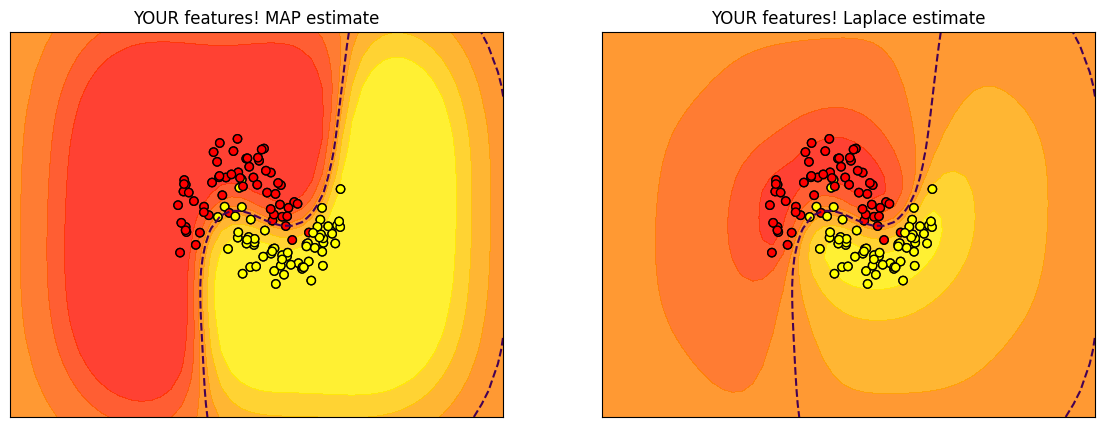

In [1709]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title("YOUR features! MAP estimate")
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_student(X), w_MAP_student))

plt.subplot(122)
plt.title("YOUR features! Laplace estimate")
plot_boundary(X_train, y_train, 
              lambda X: predict_bayes(features_student(X), w_MAP_student, Cov_student))

#### Ignore the following cells. They are used by the grading system.

In [1710]:
# (GRADING)

In [1711]:
# (GRADING)

# TASK #6 (4 points): Deep learning for features

Now that you have probably decided that choosing features by hand is annoying, let's see if we can instead learn good representations directly.

To do this, we define a network in two parts: a `FeatureNetwork` module, which takes the data and returns a `D`-dimensional feature embedding, and a `nn.Linear` layer for prediction.

In this coursework, we will do a simple two-stage approach where first we train the model end-to-end; then, we use the pre-trained features from that model in our Laplace approximation code from the previous section. This is perhaps less robust than doing a Laplace approximation across all parameters (it is only a Laplace approximation on the last linear layer), but it lets us use all our previous code.

You should implement two things:

1. The `FeatureNetwork` module itself. This should take a 2d input, and return an output of dimension `output_size`.
2. A function `train_deep_model()`, which fits the deep learning model in whatever manner you deem appropriate. Generally, I recommend fitting `model` to the training data, in order to learn the `feature_network`. You can use any choice of optimiser, parameters, early stopping, etc. **You should discuss these choices, and why, in the free response at the end.**

In [1712]:
class FeatureNetwork(nn.Module):
    def __init__(self, output_size):
        """ Initialise a network """
        super().__init__()
        self.output_size = output_size
        
        # YOUR CODE HERE
        hidden_states = 8
        self.net = nn.Sequential(
            nn.Linear(2, hidden_states),
            nn.ReLU(),
            nn.Linear(hidden_states, output_size)
        )

    def forward(self, x):
        """ Run the forward model computation """
        # YOUR CODE HERE
        value = self.net(x)
        assert value.shape == (x.shape[0], self.output_size)
        return value


# Feel free to change this (larger or smaller!) if you think appropriate!
OUTPUT_SIZE = 10

feature_network = FeatureNetwork(OUTPUT_SIZE)

# This concatenates the features from the feature network into a linear layer for prediction
model = nn.Sequential(feature_network, nn.Linear(feature_network.output_size, 1))
model

Sequential(
  (0): FeatureNetwork(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=10, bias=True)
    )
  )
  (1): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
from tqdm import tqdm

def train_deep_model():
    """ Train your model, and learn the features.

        This should update the model `model` using a pytorch optimiser, on the training set.

        Feel free to use any optimiser and regularisation techniques you think appropriate.
    """

    # You can iterate through this with `for X, y in dataloader:`
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=5)
    
    # You might prefer to use Adam for the deep network
    opt = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.01)

    # ...
    # YOUR CODE HERE
    loss_fn = nn.BCELoss()
    n_epochs = 1000

    for epoch in tqdm(range(n_epochs)):
        epoch_loss = 0.0
        
        for X_batch, y_batch in dataloader:

            opt.zero_grad()

            logits = model(X_batch).squeeze()
            probs = torch.sigmoid(logits)

            # Compute loss
            loss = loss_fn(probs, y_batch)
            
            # Backward pass
            loss.backward()
            opt.step()
            
            epoch_loss += loss.item()
    
train_deep_model()

100%|██████████| 1000/1000 [00:05<00:00, 173.61it/s]


### The following two lines take the trained feature network, and use them as an input to your existing MAP estimation code.

Your model should get a decent training accuracy (well over 80%) if everything went well.

In [1714]:
Phi_deep = feature_network(X_train).detach()
w_MAP_deep, losses = find_MAP(Phi_deep, y_train)

### Now, fit a Laplace approximation at the last layer:

In [1715]:
Cov_deep = compute_laplace_Cov(Phi_deep, y_train, w_MAP_deep)
compute_laplace_log_evidence(Phi_deep, y_train, w_MAP_deep, Cov_deep).item()

-25.604862213134766

In [1725]:
print(Phi_deep.shape)
print(features_simple(X_train).shape)

torch.Size([120, 10])
torch.Size([120, 3])


DEEP features! Model evidence estimate: -25.604862213134766


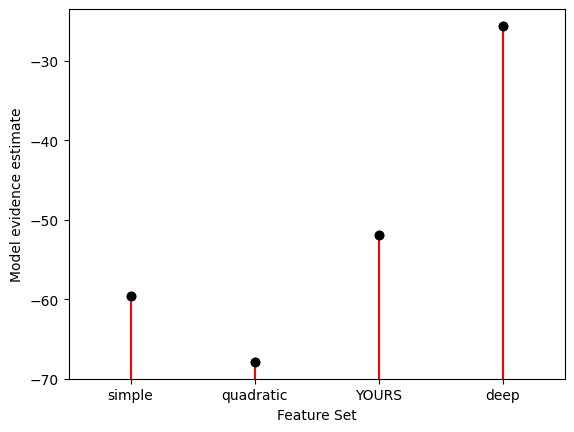

In [1716]:
print("DEEP features! Model evidence estimate:",
      compute_laplace_log_evidence(Phi_deep, y_train, w_MAP_deep, Cov_deep).item())

plot_evidence(("simple", "quadratic", "YOURS", "deep"),
              (compute_laplace_log_evidence(features_simple(X_train), y_train, w_MAP_simple, Cov_simple).item(),
               compute_laplace_log_evidence(features_quadratic(X_train), y_train, w_MAP_quad, Cov_quad).item(),
               compute_laplace_log_evidence(features_student(X_train), y_train, w_MAP_student, Cov_student).item(),
               compute_laplace_log_evidence(Phi_deep, y_train, w_MAP_deep, Cov_deep).item()))




In [1717]:
train_accuracy = (predict_probs_MAP(feature_network(X_train).detach(), w_MAP_deep).round() == y_train).float().mean()
test_accuracy = (predict_probs_MAP(feature_network(X_test).detach(), w_MAP_deep).round() == y_test).float().mean()
print("DEEP features! Training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))

DEEP features! Training accuracy = 0.93, test accuracy = 0.95


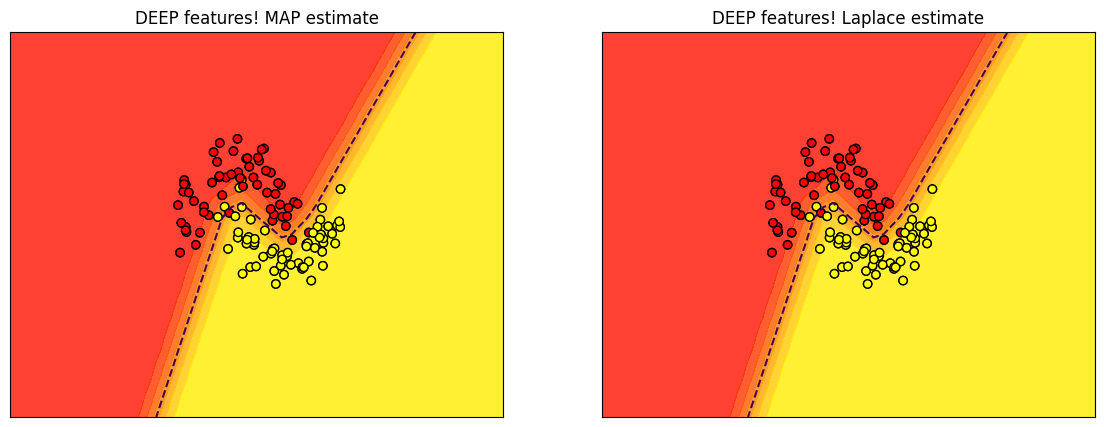

In [1718]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title("DEEP features! MAP estimate")
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(feature_network(X).detach(), w_MAP_deep))

plt.subplot(122)
plt.title("DEEP features! Laplace estimate")
plot_boundary(X_train, y_train, 
              lambda X: predict_bayes(feature_network(X).detach(), w_MAP_deep, Cov_deep))

In [1719]:
# (GRADING)

In [1720]:
# (GRADING)

In [1721]:
# (GRADING)

# Short Answer (5 points)

Please answer the following questions, now that you have compared your trained features and your hand-learned features, in **at most 150 words each**.

1. Describe your hand-chosen features. How did you decide or evalaute whether they are good features?
2. Describe your deep learning model. How did you select this model, and this training strategy? What design choices did you need to make (for either the architecture, or for training)? Are you satisfied with the results?
3. Are your deep learning features better than the hand-selected features? Why or why not? Which features would you use for later prediction?

YOUR ANSWER HERE
1.

I implemented a radial basis function (RBF) kernel, with a fixed 10x8 grid of centers and with sigma = 0.75.  RBFs generate localised features, which can capture different structures in different regions of the input space.  This is suitable for the two moons dataset, which has a complex non-linear boundary.  I conducted light empirical testing to obtain my grid size and sigma value.  My implementation resulted in 80 RBF features, and 1 intercept feature.  With only 120 samples in the training data, with 81 features we may expect overfitting.  However, looking at the model evidence and the training and test accuracy we see that these features provide good results - a significantly higher model evidence (E = -51.87) and test accuracy (A = 0.93) is reported when compared to the simple (E = -59.58, A = 0.83) and quadratic (E = -67.91, A = 0.82) models.

2.

I designed a neural network with 1 hidden layer, 8 hidden states and a ReLU activation.  I selected 1 layer as it is sufficient for universal function approximation, and 8 states through empirical testing - beyond 8 states I saw minimal change in test accuracy and diminishing gains in model evidence.  I used the Adam optimiser for its adaptive learning rates, and used the binary cross entropy (BCE) loss as we are working with binary classification.  I used 1000 epochs for training to ensure convergence.  In my Adam optimiser, I included a small weight decay of 0.01 for regularisation.  The results are good - the model achieves significantly higher evidence than all previous models (E = -25.6), as well as higher test accuracy (0.95).  The decision boundary is smooth and clearly separates the data well.

3.

The deep model has a much higher evidence than the hand-selected RBF kernel model, however this doesn't include the complexity of the neural net itself.  Nonetheless, the deep model features are learned from the data through end to end optimisation, which adapts features to this classification task without requiring manual tuning of kernel center locations or sigma.  This results in higher test accuracy for the deep model (0.95) compared to the RBF kernel model (0.93).  The tradeoff for this additional performance is in interpretability (less clear for the deep model), as well as reliability of the quantified uncertainty, which only accounts for the final layer in the deep model.  When we have limited data (such as in this case), uncertainty quantification is crucial and so the RBF model should be used for prediction (despite slightly worse performance), but with sufficient observations the deep model should be used.